In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
import numpy as np

print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.5.1+cu121


In [2]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')  # Ensure RGB format
        if self.transform:
            image = self.transform(image)
        return image

In [3]:
# Define transforms: Resize, Crop, Tensor, Normalize
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),  # Converts to [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalized to [-1, 1]
])

# Dataset path
dataroot = r"data\celeba\img_align_celeba"  # Modify if necessary

# Initialize Dataset
dataset = CelebADataset(root_dir=dataroot, transform=transform)

# DataLoader
batch_size = 64  # You can increase if GPU handles more
num_workers = 0  # Safe on Windows, increase on Linux/Mac

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
print(f"Total images found: {len(dataset)}")


Total images found: 202599


⏳ Time to load 1 batch: 0.56 seconds
Batch shape: torch.Size([64, 3, 64, 64])


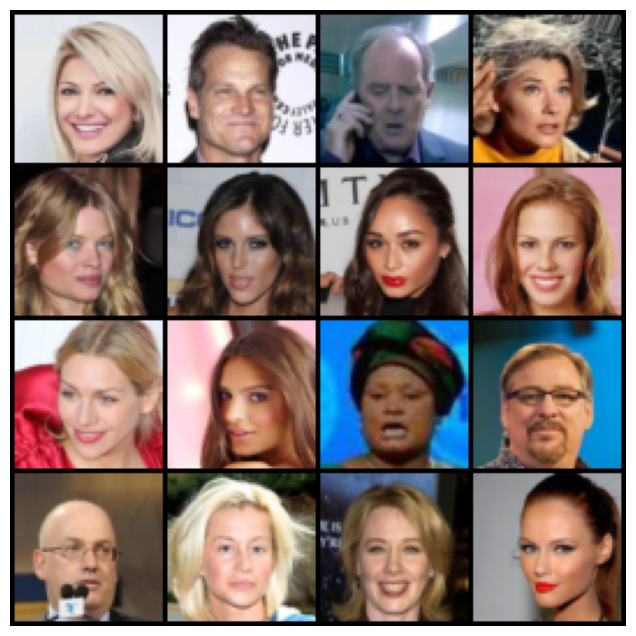

In [4]:
# %matplotlib inline  # Uncomment if running in notebook

# Simple visualization function
def show_images(batch):
    grid = torchvision.utils.make_grid(batch[:16], nrow=4, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

# Test DataLoader speed and visualization
import time
start = time.time()
data_iter = iter(dataloader)
images = next(data_iter)
end = time.time()
print(f"⏳ Time to load 1 batch: {end - start:.2f} seconds")
print(f"Batch shape: {images.shape}")

# Show images
show_images(images)

In [5]:
import torch.nn as nn

# Generator class
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input Z -> (nz) x 1 x 1
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # State size: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # State size: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # State size: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # State size: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()  # Output between [-1, 1]
        )

    def forward(self, input):
        return self.main(input)

In [6]:
# Discriminator class
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Output between [0, 1] for real/fake
        )

    def forward(self, input):
        return self.main(input).view(-1)

In [7]:
# Hyperparameters
nz = 100  # Latent vector size
ngf = 64  # Generator feature maps
ndf = 64  # Discriminator feature maps
nc = 3    # Number of channels (RGB)

# Instantiate models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(nc, ndf).to(device)

# Print model summaries
print("Generator Architecture:\n", netG)
print("\nDiscriminator Architecture:\n", netD)

Using device: cuda
Generator Architecture:
 Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding

In [8]:
# Custom weights initialization called on Generator and Discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Apply weights
netG.apply(weights_init)
netD.apply(weights_init)
print("Weights initialized.")

Weights initialized.


In [9]:
# Loss function
criterion = nn.BCELoss()

# Optimizers
lr = 0.0002
beta1 = 0.5

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

print("Loss and optimizers are set.")

# Create checkpoints directory if it doesn't exist
os.makedirs('checkpoints', exist_ok=True)

Loss and optimizers are set.


In [10]:
num_epochs = 10
real_label = 1.0
fake_label = 0.0

print("Starting Training...")

for epoch in range(num_epochs):
    # Add tqdm progress bar to dataloader
    pbar = tqdm(enumerate(dataloader, 0), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for i, data in pbar:
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()
        real_data = data.to(device)
        b_size = real_data.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # Train with real data
        output = netD(real_data)
        errD_real = criterion(output, label)
        errD_real.backward()

        # Train with fake data
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        ############################
        # (2) Update G network 3 times
        ###########################
        g_loss_accum = 0  # For averaging G loss over 3 steps
        for _ in range(3):
            netG.zero_grad()
            noise = torch.randn(b_size, nz, 1, 1, device=device)  # Fresh noise each time
            fake = netG(noise)
            label.fill_(real_label)  # Generator wants D to believe it's real
            output = netD(fake)
            errG = criterion(output, label)
            errG.backward()
            optimizerG.step()
            g_loss_accum += errG.item()

        avg_g_loss = g_loss_accum / 3  # Average G loss over 3 steps

        # Update tqdm progress bar with current losses
        pbar.set_postfix({
            'Loss_D': f'{(errD_real + errD_fake).item():.4f}',
            'Loss_G': f'{avg_g_loss:.4f}'
        })

    # Save models every epoch
    torch.save(netG.state_dict(), f'checkpoints/netG_epoch_{epoch+1}.pth')
    torch.save(netD.state_dict(), f'checkpoints/netD_epoch_{epoch+1}.pth')
    print(f"✅ Saved checkpoints for epoch {epoch+1}")

print("🎉 Training complete!")

Starting Training...


Epoch 1/10: 100%|██████████| 3166/3166 [28:02<00:00,  1.88it/s, Loss_D=1.4463, Loss_G=0.6808]


✅ Saved checkpoints for epoch 1


Epoch 2/10: 100%|██████████| 3166/3166 [13:00<00:00,  4.06it/s, Loss_D=1.4184, Loss_G=0.6939]


✅ Saved checkpoints for epoch 2


Epoch 3/10: 100%|██████████| 3166/3166 [06:27<00:00,  8.17it/s, Loss_D=1.4184, Loss_G=0.6831]


✅ Saved checkpoints for epoch 3


Epoch 4/10: 100%|██████████| 3166/3166 [06:27<00:00,  8.17it/s, Loss_D=1.4514, Loss_G=0.7814]


✅ Saved checkpoints for epoch 4


Epoch 5/10: 100%|██████████| 3166/3166 [06:28<00:00,  8.15it/s, Loss_D=1.1651, Loss_G=0.7801]


✅ Saved checkpoints for epoch 5


Epoch 6/10: 100%|██████████| 3166/3166 [07:23<00:00,  7.14it/s, Loss_D=1.3224, Loss_G=0.5433]


✅ Saved checkpoints for epoch 6


Epoch 7/10: 100%|██████████| 3166/3166 [07:49<00:00,  6.75it/s, Loss_D=0.5666, Loss_G=1.5952]


✅ Saved checkpoints for epoch 7


Epoch 8/10: 100%|██████████| 3166/3166 [29:38<00:00,  1.78it/s, Loss_D=0.4321, Loss_G=1.3206]  


✅ Saved checkpoints for epoch 8


Epoch 9/10: 100%|██████████| 3166/3166 [09:04<00:00,  5.82it/s, Loss_D=0.2422, Loss_G=2.8122]


✅ Saved checkpoints for epoch 9


Epoch 10/10: 100%|██████████| 3166/3166 [28:48<00:00,  1.83it/s, Loss_D=0.2281, Loss_G=3.1853]

✅ Saved checkpoints for epoch 10
🎉 Training complete!


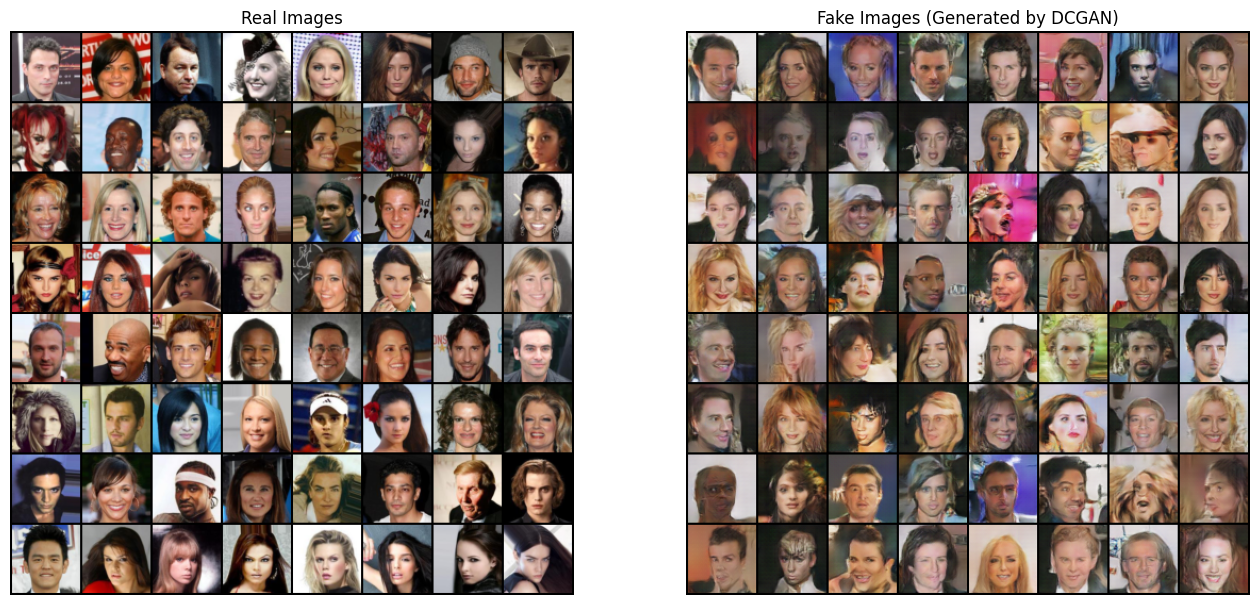

In [11]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Generate a batch of fake images
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
fake_images = netG(fixed_noise).detach().cpu()
real_images = next(iter(dataloader))[:64]  # Take first 64 real images
real_images = real_images.cpu()

# Denormalize images (from [-1, 1] to [0, 1])
def denorm(img):
    return (img + 1) / 2

# Plotting
plt.figure(figsize=(16, 8))

# Real Images
plt.subplot(1, 2, 1)
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(denorm(real_images), padding=2, normalize=False), (1, 2, 0)))
plt.axis("off")

# Fake Images
plt.subplot(1, 2, 2)
plt.title("Fake Images (Generated by DCGAN)")
plt.imshow(np.transpose(vutils.make_grid(denorm(fake_images), padding=2, normalize=False), (1, 2, 0)))
plt.axis("off")

plt.show()